--- Starting Figure Generation ---

Loading Plowman data...
Loading data from ../data/PLOWMAN/03_morphometrics_output/original_pca_scores_and_class_labels.h5
Loading PCA parameters from ../data/PLOWMAN/03_morphometrics_output/leaf_pca_model_parameters.h5
Data loaded for ../data/PLOWMAN/

Loading Cultivated1st data...
Loading data from ../data/CULTIVATED1ST/03_morphometrics_output_cultivated1st/original_pca_scores_and_class_labels.h5
Loading PCA parameters from ../data/CULTIVATED1ST/03_morphometrics_output_cultivated1st/leaf_pca_model_parameters.h5
Data loaded for ../data/CULTIVATED1ST/

Loading Wild Species data...
Loading proc_arr from ../data/WILDSPECIES/00_proc_arr.npy
Loading metadata from ../data/WILDSPECIES/01_metadata.csv
Performing PCA on data from ../data/WILDSPECIES/00_proc_arr.npy...
Data loaded and PCA performed for ../data/WILDSPECIES/00_proc_arr.npy

Global PC1 Limits (Plowman/Cultivated1st Combined): (-0.18, 0.24)
Global PC2 Limits (Plowman/Cultivated1st Combined): (-0.0

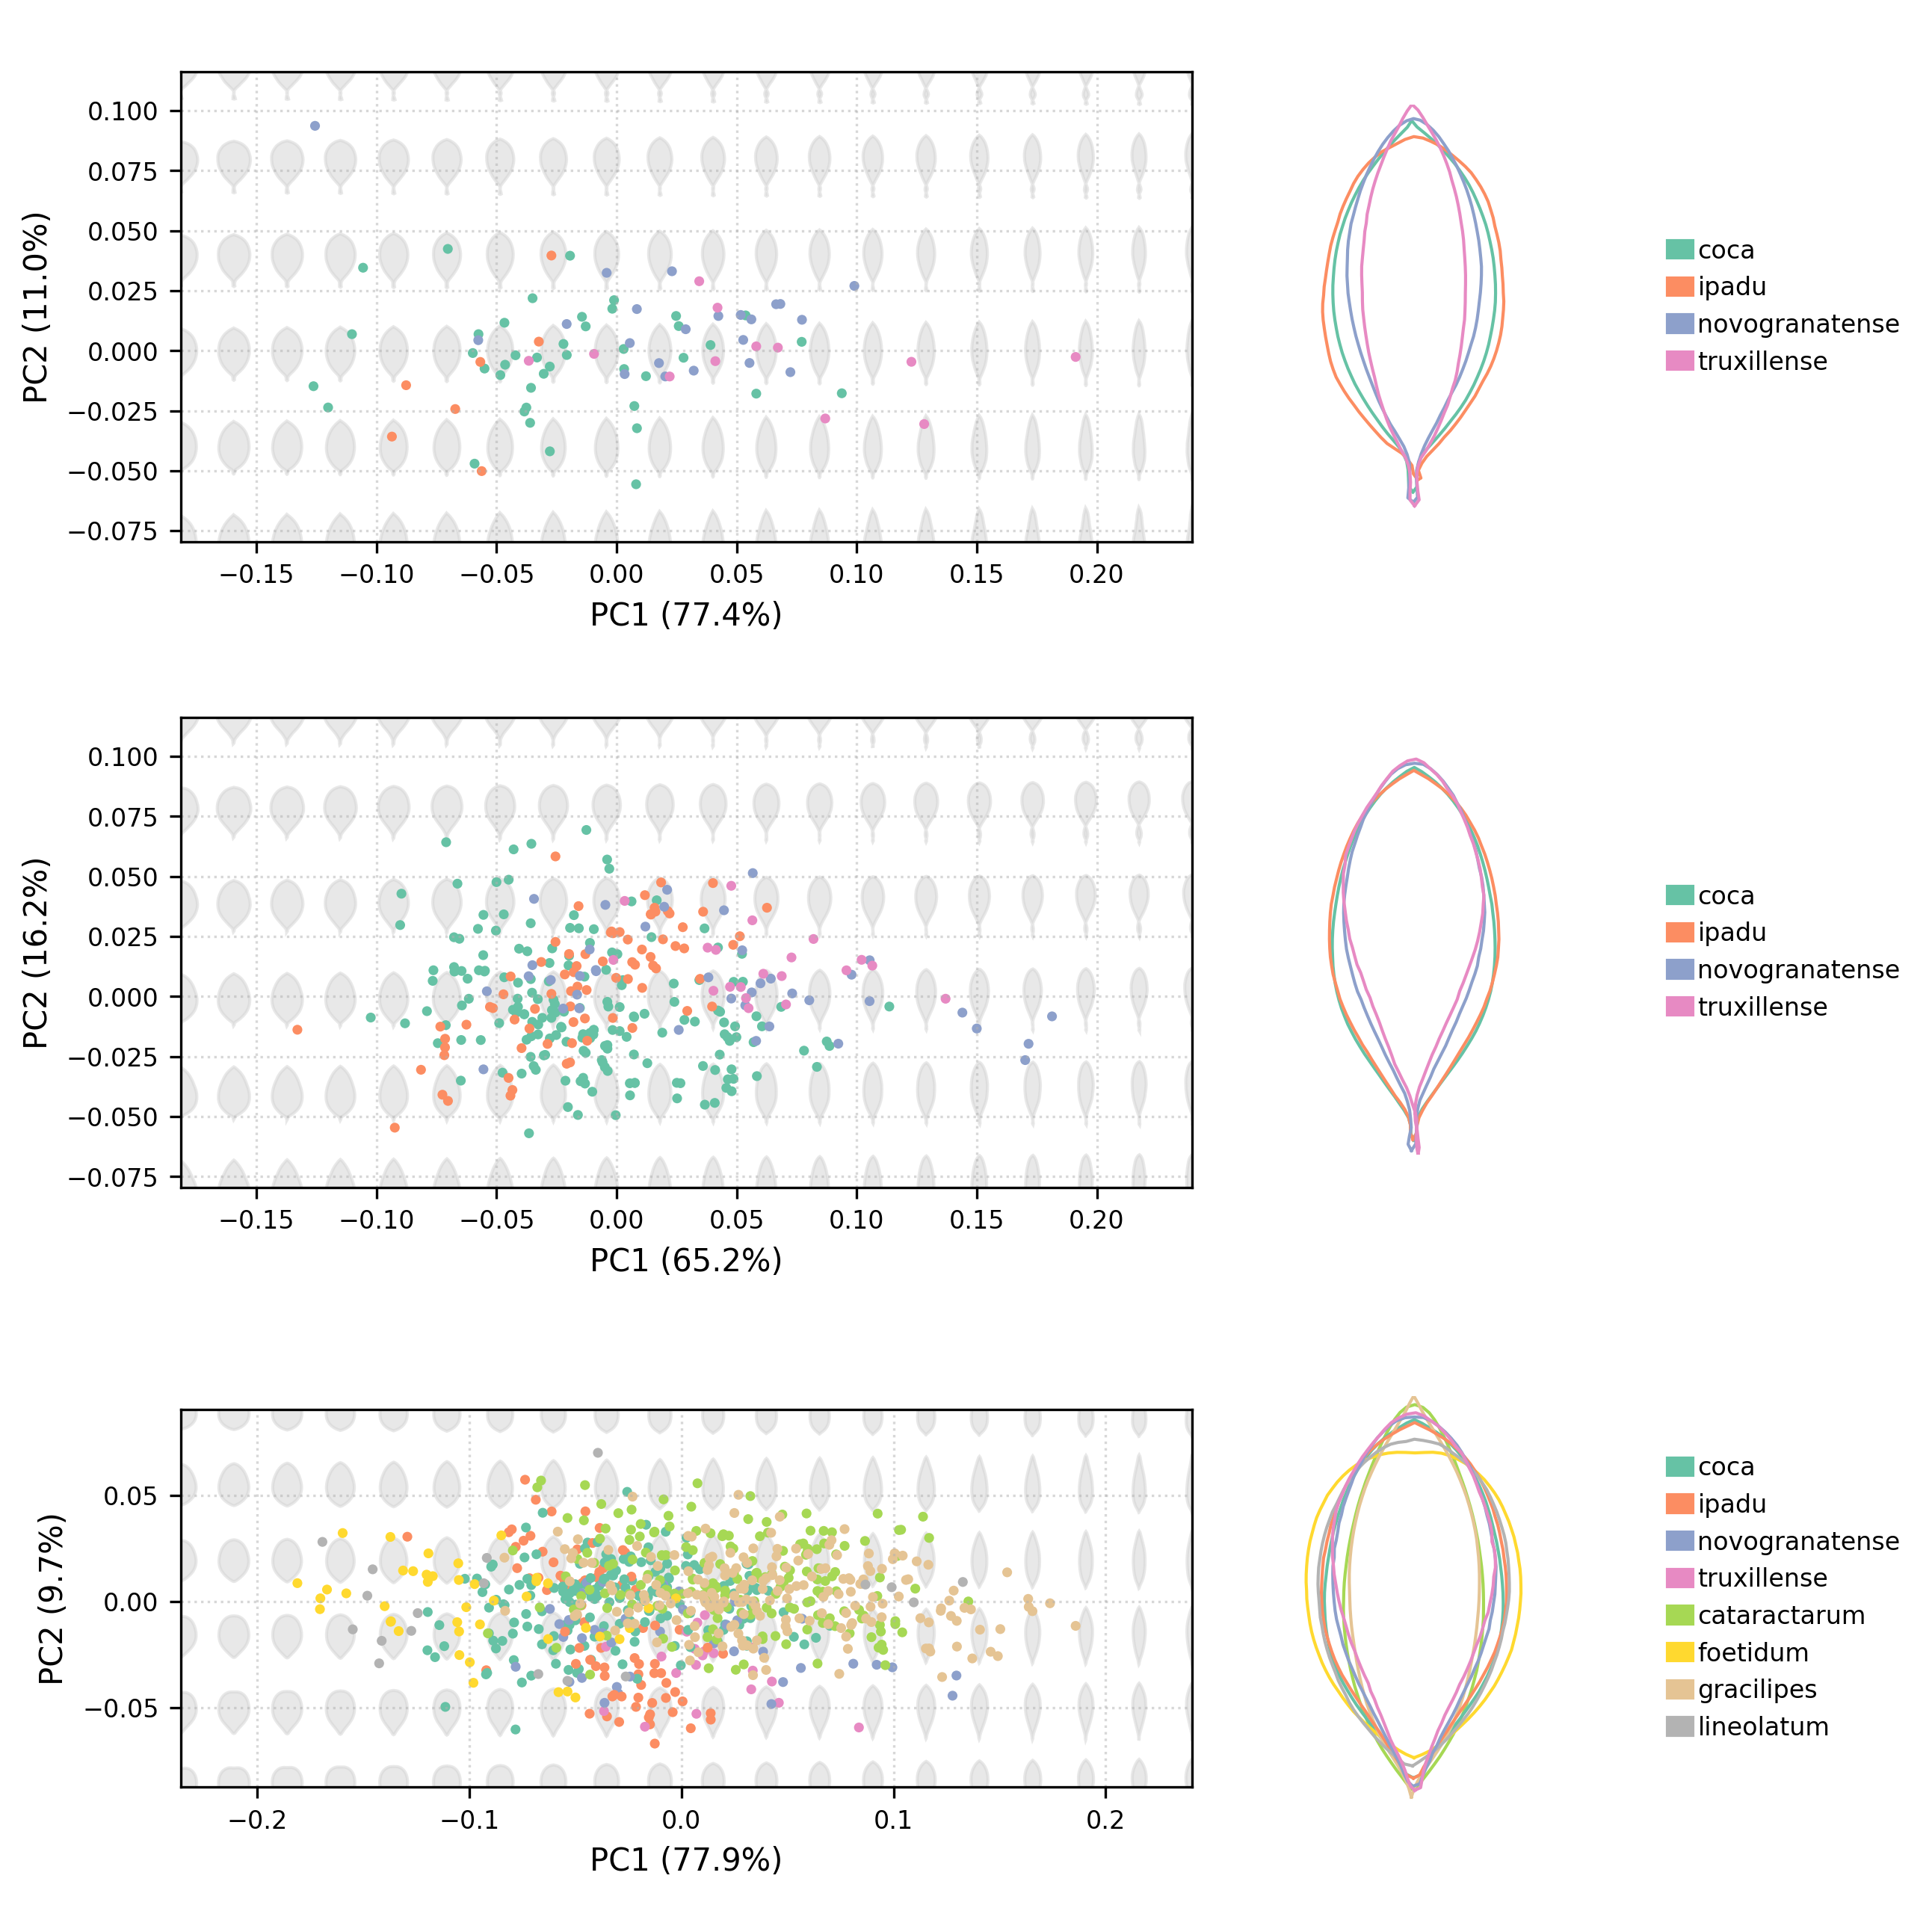

--- Figure Generation Complete ---


In [26]:
#######################
### LOAD IN MODULES ###
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from sklearn.decomposition import PCA
from matplotlib.patches import Patch # For simplified legend patches

# Ensure consistent plotting style for publication
plt.style.use('seaborn-v0_8-deep')

############################
### GLOBAL CONFIGURATION ###
############################

# --- File Paths ---
PLOWMAN_BASE_DIR = "../data/PLOWMAN/"
CULTIVATED1ST_BASE_DIR = "../data/CULTIVATED1ST/"
WILDSPECIES_BASE_DIR = "../data/WILDSPECIES/"

MORPHOMETRICS_OUTPUT_SUBDIR_PLOWMAN = "03_morphometrics_output/"
MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST = "03_morphometrics_output_cultivated1st/"

# Filenames for HDF5 outputs (used by Plowman and Cultivated1st)
PCA_PARAMS_FILENAME = "leaf_pca_model_parameters.h5"
PCA_SCORES_LABELS_FILENAME = "original_pca_scores_and_class_labels.h5"

# Filenames for new Wild Species data (from your direct .npy and .csv)
WILDSPECIES_PROC_ARRAY_FILENAME = "00_proc_arr.npy"
WILDSPECIES_METADATA_FILENAME = "01_metadata.csv"
WILDSPECIES_METADATA_CLASS_COLUMN = "type" # Column name for class labels in metadata

# Output directory for figures
FIGURES_OUTPUT_DIR = "../figures/"
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- Figure Parameters ---
PAGE_WIDTH_INCHES = 8.5
DPI = 300

NUM_MORPHOSPACES = 3 # Still 3 rows for the morphospaces

# General font sizes
AXIS_LABEL_FONTSIZE = 10
AXIS_TICK_FONTSIZE = 8
LEGEND_FONTSIZE = 8 # Smaller for the narrow legend column

# --- Plotting Specifics for Morphospace ---
EIGENLEAF_SCALE_FACTOR = 0.08
EIGENLEAF_COLOR = "lightgray"
EIGENLEAF_ALPHA = 0.5
POINT_SIZE = 10 # Adjusted per user feedback
POINT_ALPHA = 1 # Adjusted per user feedback
POINT_LINEWIDTH = 0

# --- Mean Outlines Plotting ---
MEAN_OUTLINE_LINEWIDTH = 1.0 # Adjusted per user feedback
MEAN_OUTLINE_SCALE_FACTOR = 1.0 # Adjusted per user feedback (fits better with exaggeration)
SHAPE_EXAGGERATION_FACTOR = 1.0 # NEW: Factor to amplify shape differences

# --- Global Color Palette ---
# Full 8-class order (used for WildSpecies and for generating the global palette)
FULL_8CLASS_LEGEND_ORDER = [
    'coca', 'ipadu', 'novogranatense', 'truxillense',
    'cataractarum', 'foetidum', 'gracilipes', 'lineolatum'
]
# Default order for 4-class legends (Plowman, Cultivated1st)
DEFAULT_4CLASS_LEGEND_ORDER = ['coca', 'ipadu', 'novogranatense', 'truxillense']


# Dynamically create a palette for all 8 classes using Set1
# The keys of CLASS_COLORS need to match the actual class labels.
# Use FULL_8CLASS_LEGEND_ORDER to ensure mapping is consistent.
PALETTE = sns.color_palette('Set2', n_colors=len(FULL_8CLASS_LEGEND_ORDER))
CLASS_COLORS = {cls: PALETTE[i] for i, cls in enumerate(FULL_8CLASS_LEGEND_ORDER)}


# Number of landmarks and dimensions (consistent for all datasets)
NUM_LANDMARKS = (50 * 2) - 1 # Assuming 99 landmarks as per previous calculations
NUM_DIMENSIONS = 2

# NEW: Margin factor for plots to prevent clipping of points/eigenleaves
PLOT_MARGIN_FACTOR = 0.15

#########################
### HELPER FUNCTIONS ###
#########################

def load_morphometrics_data_from_h5(base_dir, morphometrics_subdir):
    """
    Loads PCA scores, class labels, original flattened coordinates,
    and PCA model parameters for a given dataset from HDF5 files,
    and calculates average shapes per class. Used for Plowman and Cultivated1st.
    """
    output_dir = os.path.join(base_dir, morphometrics_subdir)

    pca_scores_labels_path = os.path.join(output_dir, PCA_SCORES_LABELS_FILENAME)
    pca_params_path = os.path.join(output_dir, PCA_PARAMS_FILENAME)

    data = {}

    print(f"Loading data from {pca_scores_labels_path}")
    with h5py.File(pca_scores_labels_path, 'r') as f:
        data['pc_scores'] = f['pca_scores'][:]
        data['class_labels'] = f['class_labels'][:].astype(str)
        data['original_flattened_coords'] = f['original_flattened_coords'][:]

    print(f"Loading PCA parameters from {pca_params_path}")
    with h5py.File(pca_params_path, 'r') as f:
        data['pca_components'] = f['components'][:]
        data['pca_mean'] = f['mean'][:]
        data['pca_explained_variance_ratio'] = f['explained_variance_ratio'][:]
        data['num_pca_components'] = f.attrs['n_components']

    data['num_dimensions'] = NUM_DIMENSIONS
    data['num_landmarks'] = data['original_flattened_coords'].shape[1] // data['num_dimensions']

    # Calculate and store average shapes per class
    average_shapes = {}
    unique_classes = np.unique(data['class_labels'])
    for cls in unique_classes:
        class_indices = (data['class_labels'] == cls)
        class_coords_flat = data['original_flattened_coords'][class_indices]
        class_coords_3d = class_coords_flat.reshape(-1, data['num_landmarks'], data['num_dimensions'])
        avg_shape = np.mean(class_coords_3d, axis=0)
        average_shapes[cls] = avg_shape
    data['average_shapes_by_class'] = average_shapes

    print(f"Data loaded for {base_dir}")
    return data

def load_precomputed_morphometrics_data_from_npy_csv(proc_arr_path, metadata_path, class_column_name):
    """
    Loads Procrustes array and metadata from .npy and .csv files,
    performs PCA, and calculates average shapes per class. Used for WildSpecies.
    """
    data = {}
    print(f"Loading proc_arr from {proc_arr_path}")
    proc_arr_3d = np.load(proc_arr_path)
    data['original_flattened_coords'] = proc_arr_3d.reshape(proc_arr_3d.shape[0], -1)

    print(f"Loading metadata from {metadata_path}")
    mdata_df = pd.read_csv(metadata_path)
    data['class_labels'] = mdata_df[class_column_name].values.astype(str)

    data['num_dimensions'] = proc_arr_3d.shape[2]
    data['num_landmarks'] = proc_arr_3d.shape[1]

    # Perform PCA on this dataset
    print(f"Performing PCA on data from {proc_arr_path}...")
    n_components_pca = min(data['original_flattened_coords'].shape[0], data['original_flattened_coords'].shape[1])
    
    full_pca = PCA(n_components=n_components_pca)
    full_pca.fit(data['original_flattened_coords'])
    data['pca_explained_variance_ratio'] = full_pca.explained_variance_ratio_

    plotting_pca = PCA(n_components=2)
    data['pc_scores'] = plotting_pca.fit_transform(data['original_flattened_coords'])
    data['pca_components'] = plotting_pca.components_
    data['pca_mean'] = plotting_pca.mean_
    data['num_pca_components'] = plotting_pca.n_components_

    # Calculate and store average shapes per class
    average_shapes = {}
    unique_classes = np.unique(data['class_labels'])
    for cls in unique_classes:
        class_indices = (data['class_labels'] == cls)
        class_coords_flat = data['original_flattened_coords'][class_indices]
        class_coords_3d = class_coords_flat.reshape(-1, data['num_landmarks'], data['num_dimensions'])
        avg_shape = np.mean(class_coords_3d, axis=0)
        average_shapes[cls] = avg_shape
    data['average_shapes_by_class'] = average_shapes

    print(f"Data loaded and PCA performed for {proc_arr_path}")
    return data

def plot_morphospace_panel(ax_main, data, class_colors, global_pc_limits=None):
    """
    Plots a single morphospace panel including scatter plot and eigenleaf grid.
    Titles are now handled by the main figure caption or surrounding text.
    """
    # Scatter plot
    sns.scatterplot(
        x=data['pc_scores'][:, 0], y=data['pc_scores'][:, 1],
        hue=data['class_labels'],
        palette=class_colors,
        s=POINT_SIZE, linewidth=POINT_LINEWIDTH, alpha=POINT_ALPHA,
        ax=ax_main,
        legend=False # Legend handled by separate column
    )

    # Set axis limits
    if global_pc_limits:
        ax_main.set_xlim(global_pc_limits['pc1_min'], global_pc_limits['pc1_max'])
        ax_main.set_ylim(global_pc_limits['pc2_min'], global_pc_limits['pc2_max'])
        pc1_min_plot, pc1_max_plot = global_pc_limits['pc1_min'], global_pc_limits['pc1_max']
        pc2_min_plot, pc2_max_plot = global_pc_limits['pc2_min'], global_pc_limits['pc2_max']
    else: # If no global limits, use data's own extent with a margin
        pc1_min_data, pc1_max_data = data['pc_scores'][:, 0].min(), data['pc_scores'][:, 0].max()
        pc2_min_data, pc2_max_data = data['pc_scores'][:, 1].min(), data['pc_scores'][:, 1].max()
        
        pc1_range = pc1_max_data - pc1_min_data
        pc2_range = pc2_max_data - pc2_min_data
        
        pc1_min_plot = pc1_min_data - pc1_range * PLOT_MARGIN_FACTOR
        pc1_max_plot = pc1_max_data + pc1_range * PLOT_MARGIN_FACTOR
        pc2_min_plot = pc2_min_data - pc2_range * PLOT_MARGIN_FACTOR
        pc2_max_plot = pc2_max_data + pc2_range * PLOT_MARGIN_FACTOR
        
        ax_main.set_xlim(pc1_min_plot, pc1_max_plot)
        ax_main.set_ylim(pc2_min_plot, pc2_max_plot)
    
    # Create PC intervals for plotting inverse eigenleaves based on *actual plotted limits*
    MORPHOSPACE_PC1_INTERVALS = 20
    MORPHOSPACE_PC2_INTERVALS = 6

    PC1_vals = np.linspace(pc1_min_plot, pc1_max_plot, MORPHOSPACE_PC1_INTERVALS)
    PC2_vals = np.linspace(pc2_min_plot, pc2_max_plot, MORPHOSPACE_PC2_INTERVALS)

    # Plot inverse eigenleaves (the background grid shapes)
    pca_components_2d = data['pca_components'][:2, :]
    pca_mean_flat = data['pca_mean']

    for i in PC1_vals:
        for j in PC2_vals:
            reconstructed_flat_shape = (np.array([i, j]) @ pca_components_2d) + pca_mean_flat
            reconstructed_shape_2d = reconstructed_flat_shape.reshape(data['num_landmarks'], data['num_dimensions'])
            ax_main.fill(reconstructed_shape_2d[:, 0] * EIGENLEAF_SCALE_FACTOR + i,
                         reconstructed_shape_2d[:, 1] * EIGENLEAF_SCALE_FACTOR + j,
                         color=EIGENLEAF_COLOR, alpha=EIGENLEAF_ALPHA, zorder=-1)

    # Set axis labels with explained variance from the first two PCs
    exp_var_pc1 = data['pca_explained_variance_ratio'][0] * 100
    exp_var_pc2 = data['pca_explained_variance_ratio'][1] * 100

    ax_main.set_xlabel(f"PC1 ({exp_var_pc1:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.set_ylabel(f"PC2 ({exp_var_pc2:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.set_aspect('equal', adjustable='box')
    ax_main.set_facecolor('white')
    ax_main.grid(True, linestyle=':', alpha=0.5)


def plot_mean_outlines(ax, data, class_colors):
    """
    Plots the mean leaf outline for each class in the dataset, with exaggeration.
    Titles are removed.
    """
    ax.clear()
    ax.set_axis_off()

    average_shapes = data['average_shapes_by_class']
    classes_in_data = np.unique(data['class_labels']) # Get unique classes actually present in this data

    if not average_shapes: # Handle case where no average shapes are present
        return

    overall_mean_shape_flat = data['pca_mean']
    overall_mean_shape_2d = overall_mean_shape_flat.reshape(data['num_landmarks'], data['num_dimensions'])

    exaggerated_shapes_to_plot = {} # Store exaggerated shapes temporarily

    # 1. Calculate all exaggerated shapes and find their max extent
    max_exaggerated_extent = 0
    for cls in classes_in_data:
        if cls in average_shapes: # Ensure the class has a defined average shape
            avg_shape_2d = average_shapes[cls]

            # Exaggerate the shape difference from the overall mean
            # (avg_shape - overall_mean) is the deviation vector
            # Add amplified deviation back to the average shape
            exaggerated_shape = avg_shape_2d + SHAPE_EXAGGERATION_FACTOR * (avg_shape_2d - overall_mean_shape_2d)
            
            # Center the exaggerated shape to calculate its extent for scaling
            centered_exaggerated_shape = exaggerated_shape - np.mean(exaggerated_shape, axis=0)
            max_exaggerated_extent = max(max_exaggerated_extent, np.max(np.abs(centered_exaggerated_shape)))
            
            exaggerated_shapes_to_plot[cls] = centered_exaggerated_shape # Store centered for plotting

    if max_exaggerated_extent == 0: max_exaggerated_extent = 1 # Avoid division by zero

    # 2. Plot the (now exaggerated and pre-centered) shapes
    for cls in classes_in_data:
        if cls in exaggerated_shapes_to_plot: # Check if this class had an exaggerated shape generated
            centered_exaggerated_shape = exaggerated_shapes_to_plot[cls]
            color = class_colors.get(cls, 'black')
            
            # Scale the pre-centered shape based on the max extent found across ALL exaggerated shapes
            final_scaled_shape = (centered_exaggerated_shape / max_exaggerated_extent) * MEAN_OUTLINE_SCALE_FACTOR

            # Use ax.plot for outlines, with solid color and defined linewidth
            ax.plot(final_scaled_shape[:, 0], final_scaled_shape[:, 1],
                    color=color, linewidth=MEAN_OUTLINE_LINEWIDTH, zorder=2)

    # 3. Set fixed limits to display the scaled shapes (from -plot_limit to +plot_limit)
    # We want the shapes scaled by MEAN_OUTLINE_SCALE_FACTOR to fit within this, so set limits appropriately
    plot_limit = 1.0 # Standard unit box for scaling
    ax.set_xlim(-plot_limit, plot_limit)
    ax.set_ylim(-plot_limit, plot_limit)
    ax.set_aspect('equal', adjustable='box')


def plot_color_legend(ax, class_list, class_colors):
    """
    Creates a simple color-patch legend.
    Titles are removed.
    """
    ax.clear()
    ax.set_axis_off()

    handles = []
    labels = []
    
    # Only add patches for classes that are in the provided class_list and have a color defined
    for cls in class_list:
        if cls in class_colors:
            handles.append(Patch(color=class_colors[cls]))
            labels.append(cls)

    # Place the legend
    # bbox_to_anchor=(0.05, 0.5) positions the legend's center-left at 5% from left edge, 50% from bottom edge of the ax.
    # Adjust `columnspacing` and `handletextpad` for a narrow column.
    ax.legend(handles=handles, labels=labels, loc='center left', 
              bbox_to_anchor=(0.05, 0.5), # Small horizontal padding for the legend text
              frameon=False, fontsize=LEGEND_FONTSIZE, handlelength=1.0, handletextpad=0.2, columnspacing=0.5)

##########################
### MAIN FIGURE SCRIPT ###
##########################

print("--- Starting Figure Generation ---")

# 1. Load Data for Plowman
print("\nLoading Plowman data...")
plowman_data = load_morphometrics_data_from_h5(PLOWMAN_BASE_DIR, MORPHOMETRICS_OUTPUT_SUBDIR_PLOWMAN)

# 2. Load Data for Cultivated1st
print("\nLoading Cultivated1st data...")
cultivated1st_data = load_morphometrics_data_from_h5(CULTIVATED1ST_BASE_DIR, MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST)

# 3. Load Data for Wild Species (the new combined dataset)
print("\nLoading Wild Species data...")
wild_species_data = load_precomputed_morphometrics_data_from_npy_csv(
    os.path.join(WILDSPECIES_BASE_DIR, WILDSPECIES_PROC_ARRAY_FILENAME),
    os.path.join(WILDSPECIES_BASE_DIR, WILDSPECIES_METADATA_FILENAME),
    WILDSPECIES_METADATA_CLASS_COLUMN
)

# --- Calculate Global PC Limits for consistent plot scaling for Plowman and Cultivated1st ---
# (This still makes sense for plots that are meant to be compared directly in PC space)
all_pc_scores_cultivated = np.vstack((plowman_data['pc_scores'][:, :2], cultivated1st_data['pc_scores'][:, :2]))

global_pc1_min_raw, global_pc1_max_raw = all_pc_scores_cultivated[:, 0].min(), all_pc_scores_cultivated[:, 0].max()
global_pc2_min_raw, global_pc2_max_raw = all_pc_scores_cultivated[:, 1].min(), all_pc_scores_cultivated[:, 1].max()

global_pc1_range = global_pc1_max_raw - global_pc1_min_raw
global_pc2_range = global_pc2_max_raw - global_pc2_min_raw

global_pc_limits_cultivated = {
    'pc1_min': global_pc1_min_raw - global_pc1_range * PLOT_MARGIN_FACTOR,
    'pc1_max': global_pc1_max_raw + global_pc1_range * PLOT_MARGIN_FACTOR,
    'pc2_min': global_pc2_min_raw - global_pc2_range * PLOT_MARGIN_FACTOR,
    'pc2_max': global_pc2_max_raw + global_pc2_range * PLOT_MARGIN_FACTOR
}

print(f"\nGlobal PC1 Limits (Plowman/Cultivated1st Combined): ({global_pc_limits_cultivated['pc1_min']:.2f}, {global_pc_limits_cultivated['pc1_max']:.2f})")
print(f"Global PC2 Limits (Plowman/Cultivated1st Combined): ({global_pc_limits_cultivated['pc2_min']:.2f}, {global_pc_limits_cultivated['pc2_max']:.2f})")


# --- Dynamically adjust panel height to match data aspect ratio ---
# We need an approximate aspect ratio from the data for scaling figure height
# Using the combined cultivated data for this
data_aspect_ratio = (global_pc1_max_raw - global_pc1_min_raw) / \
                    (global_pc2_max_raw - global_pc2_min_raw)

# Define column width ratios as discussed: Main (5), Outlines (2), Legend (1)
COL_MAIN_MORPHOSPACE_RATIO = 5
COL_MEAN_OUTLINES_RATIO = 2
COL_SIMPLE_LEGEND_RATIO = 1
TOTAL_COL_RATIO = COL_MAIN_MORPHOSPACE_RATIO + COL_MEAN_OUTLINES_RATIO + COL_SIMPLE_LEGEND_RATIO

# Calculate the effective width ratio for a single main morphospace plot
MAIN_PLOT_EFFECTIVE_WIDTH_RATIO = COL_MAIN_MORPHOSPACE_RATIO / TOTAL_COL_RATIO

# Calculate height per main morphospace panel based on its desired aspect ratio
HEIGHT_PER_MORPHOSPACE_PANEL_INCHES = (MAIN_PLOT_EFFECTIVE_WIDTH_RATIO * PAGE_WIDTH_INCHES) / data_aspect_ratio

# Total figure height: sum of main panel heights + padding for titles and overall figure margins.
# Added some buffer for space between rows.
TOTAL_VERTICAL_PADDING_INCHES = (0.35 * NUM_MORPHOSPACES) # Roughly for inter-row space and labels.
FIGURE_HEIGHT_INCHES = (NUM_MORPHOSPACES * HEIGHT_PER_MORPHOSPACE_PANEL_INCHES) + TOTAL_VERTICAL_PADDING_INCHES

print(f"Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_INCHES: {HEIGHT_PER_MORPHOSPACE_PANEL_INCHES:.2f} inches")
print(f"Resulting FIGURE_HEIGHT_INCHES (with padding): {FIGURE_HEIGHT_INCHES:.2f} inches")


# 3. Define Figure Layout using GridSpec (3 rows, 3 columns)
fig = plt.figure(figsize=(PAGE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES), dpi=DPI,
                 constrained_layout=True)

# Set padding for constrained_layout
fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.08, wspace=0.03, hspace=0.05)


gs = fig.add_gridspec(
    nrows=NUM_MORPHOSPACES, ncols=3,
    height_ratios=[1]*NUM_MORPHOSPACES, # Equal height for each row
    width_ratios=[COL_MAIN_MORPHOSPACE_RATIO, COL_MEAN_OUTLINES_RATIO, COL_SIMPLE_LEGEND_RATIO]
)

# 4. Plot Plowman Row (Morphospace, Mean Outlines, Legend)
print("\nPlotting Plowman row...")
ax_plowman_main = fig.add_subplot(gs[0, 0])
plot_morphospace_panel(ax_plowman_main, plowman_data,
                       class_colors=CLASS_COLORS,
                       global_pc_limits=global_pc_limits_cultivated)

ax_plowman_outlines = fig.add_subplot(gs[0, 1])
plot_mean_outlines(ax_plowman_outlines, plowman_data, CLASS_COLORS)

ax_plowman_legend = fig.add_subplot(gs[0, 2])
plot_color_legend(ax_plowman_legend, DEFAULT_4CLASS_LEGEND_ORDER, CLASS_COLORS)


# 5. Plot Cultivated1st Row (Morphospace, Mean Outlines, Legend)
print("Plotting Cultivated1st row...")
# Removed sharex/sharey to allow independent axes for each morphospace
ax_cultivated1st_main = fig.add_subplot(gs[1, 0]) 
plot_morphospace_panel(ax_cultivated1st_main, cultivated1st_data,
                       class_colors=CLASS_COLORS,
                       global_pc_limits=global_pc_limits_cultivated)

ax_cultivated1st_outlines = fig.add_subplot(gs[1, 1])
plot_mean_outlines(ax_cultivated1st_outlines, cultivated1st_data, CLASS_COLORS)

ax_cultivated1st_legend = fig.add_subplot(gs[1, 2])
plot_color_legend(ax_cultivated1st_legend, DEFAULT_4CLASS_LEGEND_ORDER, CLASS_COLORS)


# 6. Plot Wild Species Row (Morphospace, Mean Outlines, Legend)
print("Plotting Wild Species row...")
ax_wild_main = fig.add_subplot(gs[2, 0]) 
plot_morphospace_panel(ax_wild_main, wild_species_data,
                       class_colors=CLASS_COLORS,
                       global_pc_limits=None) # This panel uses its own calculated limits

ax_wild_outlines = fig.add_subplot(gs[2, 1])
plot_mean_outlines(ax_wild_outlines, wild_species_data, CLASS_COLORS)

ax_wild_legend = fig.add_subplot(gs[2, 2])
plot_color_legend(ax_wild_legend, FULL_8CLASS_LEGEND_ORDER, CLASS_COLORS)


# 7. Final Adjustments and Saving
output_filename = "Combined_Morphospaces_3x3_ExaggeratedMeanOutlines.png" # Updated filename
plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, output_filename), dpi=DPI, bbox_inches='tight')
print(f"\nFigure saved to: {os.path.join(FIGURES_OUTPUT_DIR, output_filename)}")

plt.show()
print("--- Figure Generation Complete ---")